In [48]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats


In [95]:
c = 0
p = '/Users/pmahableshwarkar/Documents/Depth_Project/TAC_data'
# p = '/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/oct19_data'
for file in os.listdir(p):
    c += 1
c

327

In [96]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    exclude: list of subject IDs that should be excluded from the final df 
    """
    
    exclude = [764036, 893334, 192813, 485648, 920545, 699567, 277612, 568975,
       949355, 651218, 297210, 284316, 407286, 156339, 174125, 302646,
       162971, 372438, 951905, 940993, 581165, 457460, 350641, 579265,
       535676, 564312, 749256, 540104, 769506, 297386, 776784, 501020,
       392648, 206615, 506907]
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
            
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
#             input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def cleanAgeResponses(datafolder):
    input_data = getUnitConveredData(datafolder)
    
    for idx, row in input_data.iterrows():
        age = row['age']
        # if year of birth was given, convert to age
        if age > 100:
            actual_age = 2021-age
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age
        # participants must be over 18 so age reports below 18 are junk 
        if age < 18:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age    
        if 90 < age < 100:
            actual_age = None
            # update age in existing dataframe
            input_data.at[idx, 'age'] = actual_age 
    
    return input_data    
    

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = cleanAgeResponses(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(192 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
    print("Number of participants with 10% or more missed trials: ", len(remove_ids))

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)

    
    return input_data


In [97]:

# path = "/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/v2_depth_duration_MTurk/data"

# path = '/Users/prachi/Documents/depth_duration/target_at_center/v2_depth_duration/oct19_data'

path = '/Users/pmahableshwarkar/Documents/Depth_Project/TAC_data'


missed_trial_cleaned_data = removeMissedTrials(path)

Number of participants before cleaning:  291
Number of participants with 10% or more missed trials:  1


In [98]:
missed_trial_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age,gender
0,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,3.8960,1.5240,3114,249,feet,750381,902117,44,Man
1,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,1000,1.5580,0.9144,2714,1001,feet,750381,902117,44,Man
2,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,1.8915,0.9144,2163,749,feet,750381,902117,44,Man
3,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,2.1950,1.2192,2458,250,feet,750381,902117,44,Man
4,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,3.9125,1.8288,3163,749,feet,750381,902117,44,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,1.9680,5.0000,2199,251,meters,1957042,2186724,25,Man
55868,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,500,3.4400,2.0000,2820,499,meters,1957042,2186724,25,Man
55869,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,2.8000,4.0000,2394,253,meters,1957042,2186724,25,Man
55870,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,1000,3.3810,3.0000,4061,1017,meters,1957042,2186724,25,Man


#### Distribution of Unit Preferences

In [99]:
pre_unitconversion_data = combineCSVs(path)

Number of participants before cleaning:  291


In [100]:
subject_ids_pre_cleaning = pre_unitconversion_data.subjID.unique()
subj_units = {}
meters_count = 0
feet_count = 0
for subj in subject_ids_pre_cleaning:
    subj_df = pre_unitconversion_data.loc[pre_unitconversion_data['subjID'] == subj]
    unit = subj_df.unitSelection.unique()
    subj_units[subj] = unit[0]
    if unit == "feet":
        feet_count += 1
    if unit == "meters":
        meters_count += 1
    
meters_count, feet_count

(110, 181)

In [101]:

def RT_Cleaning(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # calculate subject's average trial RT 
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
#         outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))] 
        outlier_range = [1000, (average_trial_RT + (3*std_trial_RT))] 

        for idx, row in subj_df.iterrows():
            RT = row["trial_RT"]
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print("Number of Participants with 10% or more trials outside their RT range: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [102]:
RT_cleaned_data = RT_Cleaning(missed_trial_cleaned_data)

Number of Participants with 10% or more trials outside their RT range:  0


In [103]:
RT_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age,gender
0,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,3.8960,1.5240,3114,249,feet,750381,902117,44,Man
1,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,1000,1.5580,0.9144,2714,1001,feet,750381,902117,44,Man
2,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,1.8915,0.9144,2163,749,feet,750381,902117,44,Man
3,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,2.1950,1.2192,2458,250,feet,750381,902117,44,Man
4,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,3.9125,1.8288,3163,749,feet,750381,902117,44,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,1.9680,5.0000,2199,251,meters,1957042,2186724,25,Man
55868,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,500,3.4400,2.0000,2820,499,meters,1957042,2186724,25,Man
55869,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,2.8000,4.0000,2394,253,meters,1957042,2186724,25,Man
55870,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,1000,3.3810,3.0000,4061,1017,meters,1957042,2186724,25,Man


In [104]:
def participant_Outlier_Removal(df):
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    remove = []
    
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        # calculate subject's average trial RT 
        average = subj_df["depth_estimate"].mean()
        std = subj_df["depth_estimate"].std()
        outlier_range = [(average - (3*std)), (average + (3*std))]
        
        for idx, row in subj_df.iterrows():
            estim = row["depth_estimate"]
            if estim < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if estim > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                
        threshold = math.floor(192 * 0.1)
        if count >= threshold:
            remove.append(subj)
         
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
        
    print("Number of Participants with 10% or more outlier trials: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2



In [105]:
outlier_cleaned_data = participant_Outlier_Removal(RT_cleaned_data)

Number of Participants with 10% or more outlier trials:  0


In [106]:
outlier_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age,gender
0,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,3.8960,1.5240,3114,249,feet,750381,902117,44,Man
1,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,1000,1.5580,0.9144,2714,1001,feet,750381,902117,44,Man
2,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,1.8915,0.9144,2163,749,feet,750381,902117,44,Man
3,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,2.1950,1.2192,2458,250,feet,750381,902117,44,Man
4,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,3.9125,1.8288,3163,749,feet,750381,902117,44,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,1.9680,5.0000,2199,251,meters,1957042,2186724,25,Man
55868,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,500,3.4400,2.0000,2820,499,meters,1957042,2186724,25,Man
55869,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,2.8000,4.0000,2394,253,meters,1957042,2186724,25,Man
55870,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,1000,3.3810,3.0000,4061,1017,meters,1957042,2186724,25,Man


In [107]:
def getActualDepthAverage(df):
    """
    True average of target depths in the stimuli
    """
    
    avg_actual = np.mean(np.array(df['actual_depth']))
    
    return avg_actual

def participantAverageEstim_Cleaning(df):
    true_average = getActualDepthAverage(df)
    octave_window = [true_average/4, true_average * 4]
    print(true_average, octave_window)
    
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation  
        avg = subj_df['depth_estimate'].mean()
        if avg < octave_window[0]:
            remove.append(subj)
        if avg > octave_window[1]:
            remove.append(subj)
    
    print("Avg Estim Cleaning: Number of Participants Removed", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    return df 



In [108]:
avg_estim_cleaned_data = participantAverageEstim_Cleaning(outlier_cleaned_data)

3.0182145854043108 [0.7545536463510777, 12.072858341617243]
Avg Estim Cleaning: Number of Participants Removed 25


In [109]:
avg_estim_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age,gender
0,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,3.8960,1.5240,3114,249,feet,750381,902117,44,Man
1,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,1000,1.5580,0.9144,2714,1001,feet,750381,902117,44,Man
2,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,1.8915,0.9144,2163,749,feet,750381,902117,44,Man
3,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,2.1950,1.2192,2458,250,feet,750381,902117,44,Man
4,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,3.9125,1.8288,3163,749,feet,750381,902117,44,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,1.9680,5.0000,2199,251,meters,1957042,2186724,25,Man
55868,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,500,3.4400,2.0000,2820,499,meters,1957042,2186724,25,Man
55869,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,2.8000,4.0000,2394,253,meters,1957042,2186724,25,Man
55870,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,1000,3.3810,3.0000,4061,1017,meters,1957042,2186724,25,Man


In [110]:
def repeatResponses_Cleaning(df):
    """
    Some participants gave'junk data' - same number repeated for many trials 
    Count the frequency of unique responses entered by the participant. 
    If you look at the maximum number of repeats and/or the number of unique responses / 48 per participant you will find our vandals.
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    max_repeats_distribution = []
    num_unique_responses_distribution = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        # ideally, the max repeats and num_unique_responses should be ~ 48 since there are 48 imgs at each depth bin 
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        num_unique_responses = len(count_depth_estimates)
        num_unique_responses_distribution.append(num_unique_responses)
        max_repeats = count_depth_estimates.max()
        max_repeats_distribution.append(max_repeats)
        if num_unique_responses < 6:
            remove.append(subj)
    
    avg_max_repeats = np.array(max_repeats_distribution).mean()
    std_max_repeats = np.array(max_repeats_distribution).std()
    
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_depth_estimates = subj_df['depth_estimate'].value_counts()
        max_repeats = count_depth_estimates.max()

        outlierrange = [avg_max_repeats - (3*std_max_repeats), avg_max_repeats + (3*std_max_repeats)]
        if max_repeats < outlierrange[0]:
            if subj not in remove:
                remove.append(subj)
        if max_repeats > outlierrange[1]:
            if subj not in remove:
                remove.append(subj)
                
    print("Number of participants removed: repeat responses: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)

    return df, max_repeats_distribution, num_unique_responses_distribution



In [111]:
repeat_resp_cleaned_data, max_repeats_distrib, num_unique_distrib = repeatResponses_Cleaning(avg_estim_cleaned_data)

Number of participants removed: repeat responses:  70


In [112]:
repeat_resp_cleaned_data

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime,age,gender
0,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,3.8960,1.5240,3114,249,feet,750381,902117,44,Man
1,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,1000,1.5580,0.9144,2714,1001,feet,750381,902117,44,Man
2,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,1.8915,0.9144,2163,749,feet,750381,902117,44,Man
3,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,250,2.1950,1.2192,2458,250,feet,750381,902117,44,Man
4,710814,DepthScenes,duration_manipulation_targetAtFixation,jsons/ad_3.json,http://100.27.21.195/DepthDuration/v2_depth_du...,8,1600,789,1600,900,...,750,3.9125,1.8288,3163,749,feet,750381,902117,44,Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,1.9680,5.0000,2199,251,meters,1957042,2186724,25,Man
55868,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,500,3.4400,2.0000,2820,499,meters,1957042,2186724,25,Man
55869,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,250,2.8000,4.0000,2394,253,meters,1957042,2186724,25,Man
55870,107287,DepthScenes,duration_manipulation_targetAtFixation,jsons/k_1.json,http://34.238.49.31/DepthDuration/v2_depth_dur...,9,1280,609,1280,720,...,1000,3.3810,3.0000,4061,1017,meters,1957042,2186724,25,Man


In [113]:
def finalTrialCountCheck(df):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = 192 - math.floor(192 * 0.1)

        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
        
    print("Number of participants left: ",len(df.subjID.unique()))
    
    return df

In [114]:
cleaned_data = finalTrialCountCheck(repeat_resp_cleaned_data)

Number of Participants with >= 10% trials removed:  0
Number of participants left:  195


In [115]:
final_data = cleaned_data.copy(deep=True)

In [117]:
len(final_data.subjID.unique())

195

Oct 15: Repeat worker at age 48 - need to replace all 48 year old participants/sequences
- replace each sequence listed below

In [118]:
age48 = final_data.loc[final_data['age'] == 48]
len(age48.subjID.unique()), age48.sequenceName.unique()

(0, array([], dtype=object))

In [119]:
age48.subjID.unique()

array([], dtype=object)

In [120]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

2.4187572016414074

In [100]:
# list of sequences that remain in the final_data set 
len(final_data.sequenceName.unique()), final_data.sequenceName.unique()

(190,
 array(['jsons/x_2.json', 'jsons/ai_3.json', 'jsons/o_3.json',
        'jsons/z.json', 'jsons/t_3.json', 'jsons/n_2.json',
        'jsons/ad_3.json', 'jsons/au.json', 'jsons/c.json', 'jsons/j.json',
        'jsons/y_1.json', 'jsons/q_1.json', 'jsons/e_2.json',
        'jsons/l_3.json', 'jsons/m_3.json', 'jsons/v_1.json',
        'jsons/g_3.json', 'jsons/k_2.json', 'jsons/x.json',
        'jsons/i_2.json', 'jsons/k_1.json', 'jsons/o_1.json',
        'jsons/l_1.json', 'jsons/ab_1.json', 'jsons/ab.json',
        'jsons/ad_2.json', 'jsons/ag.json', 'jsons/ac_2.json',
        'jsons/m.json', 'jsons/i_1.json', 'jsons/af.json',
        'jsons/r_2.json', 'jsons/s.json', 'jsons/h_2.json',
        'jsons/am_3.json', 'jsons/s_1.json', 'jsons/j_3.json',
        'jsons/j_1.json', 'jsons/l.json', 'jsons/o.json', 'jsons/i_3.json',
        'jsons/p_3.json', 'jsons/ac_3.json', 'jsons/ai.json',
        'jsons/av_3.json', 'jsons/a.json', 'jsons/b_3.json',
        'jsons/aw_3.json', 'jsons/aj_3.json

In [123]:
# full list of sequences that need to be sampled 

all_sequences = []
# p = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/v2_depth_duration_MTurk/jsons'
# p = '/Users/prachi/Documents/depth_duration/SUN-RGBD_stimuli_prep/V2_sequences'
p = '/Users/pmahableshwarkar/Documents/Depth_Project/SUN-RGBD_stimuli_prep/V2_sequences'
for seq in os.listdir(p):
    if 'json' in seq:
        all_sequences.append('jsons/' + seq)
all_sequences[0]

'jsons/aq_2.json'

In [124]:
replace = []
for seq in all_sequences:
    if seq not in list(final_data.sequenceName.unique()):
        replace.append(seq)

len(replace), replace

(0, [])

In [77]:
# len(list_sequences_to_replace), list_sequences_to_replace

In [104]:
average_depth_estimate = np.array(final_data['depth_estimate']).mean()
average_depth_estimate

2.42332920026537

#### Unit Distribution 

In [105]:
final_subjects = final_data.subjID.unique()
num_feet = 0
num_meters = 0
feet_subjects = []
for subj in final_subjects:
    unit = subj_units[subj]
    if unit == 'feet':
        num_feet += 1
        feet_subjects.append(subj)
    else:
        num_meters += 1

num_feet, num_meters

(159, 34)

Filter data by removing participants that used meters 

In [224]:
# for subj in final_subjects:
#     if subj not in feet_subjects:
#         print(subj)
#         final_data.drop(final_data.loc[final_data['subjID']==subj].index, inplace=True)

In [39]:
len(final_data.subjID.unique())

194

### Normalize Data by Participant's Avg 

In [80]:
def normalize_dfs(df):
    """
    Args:
        final data 
    Return:
        data normalized by participants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'

    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    norm_subjects = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    return normalized_df

In [81]:
normalized_data = normalize_dfs(final_data)

#### Age

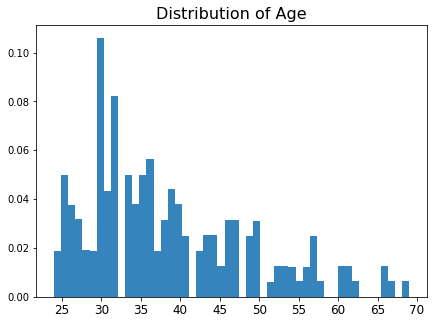

In [82]:
all_ages = final_data['age']
plt.figure(figsize = [7,5])
plt.xticks(np.arange(20,100, 5) ,fontsize=12)
# plt.yticks([])
plt.title('Distribution of Age', fontsize=16)
_, bins, _= plt.hist(all_ages, 50, density=1, alpha=0.9)
plt.show()


In [83]:
age_48_data = final_data.loc[final_data['age'] == 48]

In [84]:
# Checked and these were all associated with unique Turk Worker IDs 
len(age_48_data.subjID.unique()), age_48_data.subjID.unique()

(0, array([], dtype=object))

In [85]:
# Checked and these were all associated with unique Turk Worker IDs 
len(age_48_data.sequenceName.unique()), age_48_data.sequenceName.unique()

(0, array([], dtype=object))

In [86]:
seq_dict = {}
for subj in final_data.subjID.unique():
    subjDF = final_data.loc[final_data['subjID'] == subj]
    seq = subjDF.sequenceName.unique()[0]
    if seq not in seq_dict.keys():
        seq_dict[seq] = 1
    else:
        seq_dict[seq] += 1
#         print(subj, seq)
    if seq == 'jsons/ai.json':
        print(subj)
    if seq == 'jsons/e_2.json':
        print(subj)
    

947436
349317
957876
714857


In [87]:
seq_dict

{'jsons/ad_3.json': 1,
 'jsons/ah.json': 1,
 'jsons/al_3.json': 1,
 'jsons/ah_2.json': 1,
 'jsons/r.json': 1,
 'jsons/am_2.json': 1,
 'jsons/ai.json': 2,
 'jsons/z_2.json': 1,
 'jsons/s_2.json': 1,
 'jsons/as.json': 1,
 'jsons/au.json': 1,
 'jsons/x_3.json': 1,
 'jsons/b_1.json': 1,
 'jsons/s_3.json': 1,
 'jsons/d_2.json': 1,
 'jsons/l_1.json': 1,
 'jsons/b_2.json': 1,
 'jsons/as_1.json': 1,
 'jsons/an_3.json': 1,
 'jsons/t.json': 1,
 'jsons/i_2.json': 1,
 'jsons/h_1.json': 1,
 'jsons/q_1.json': 1,
 'jsons/n_2.json': 1,
 'jsons/e.json': 1,
 'jsons/al.json': 1,
 'jsons/q.json': 1,
 'jsons/v_1.json': 1,
 'jsons/f_3.json': 1,
 'jsons/y_2.json': 1,
 'jsons/aw_1.json': 1,
 'jsons/u_2.json': 1,
 'jsons/ar.json': 1,
 'jsons/aw.json': 1,
 'jsons/ar_3.json': 1,
 'jsons/k_2.json': 1,
 'jsons/t_3.json': 1,
 'jsons/ad_1.json': 1,
 'jsons/r_3.json': 1,
 'jsons/z.json': 1,
 'jsons/w_3.json': 1,
 'jsons/au_3.json': 1,
 'jsons/ak_3.json': 1,
 'jsons/aj_2.json': 1,
 'jsons/x.json': 1,
 'jsons/c_3.json'

In [88]:
gender_dict = {}
for subj in final_data.subjID.unique():
    subjDF = final_data.loc[final_data['subjID'] == subj]
    gender = subjDF.gender.unique()[0]
    if gender not in gender_dict.keys():
        if gender == '3 15 65':
            gender_dict['Prefer not to say'] = 1
        else:
            gender_dict[gender] = 1
    else:
        if gender == '3 15 65':
            gender_dict['Prefer not to say'] += 1
        else:
            gender_dict[gender] += 1


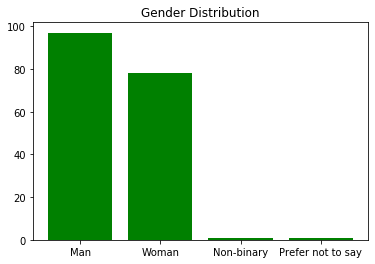

In [89]:
plt.figure();
plt.title('Gender Distribution')
plt.bar(list(gender_dict.keys()), gender_dict.values(), color='g')
plt.show();

In [91]:
gender_dict

{'Man': 97, 'Woman': 78, 'Non-binary': 1, 'Prefer not to say': 1}